Reading instruments SDA 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import os 
import glob 
import math 
import pynmea2
import re 
%matplotlib widget


In [3]:
#data directory
data_dir = 'C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data'

In [4]:
#data directory 
data_dir = 'C:/Users/ENV/OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample'

Make CR6 files hourly , only need to run once 

In [5]:

def process_cr6_hourly_data(input_path, output_path):
    """
    Process CR6 data files to group and filter data by hour,
    saving output files in a single directory.
    
    Args:
    input_path (str): Directory containing CR6 data files
    output_path (str): Directory to save processed hourly files
    """
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Collect all .dat files in the input directory
    data_files = [f for f in os.listdir(input_path) if f.endswith('.dat') and f.startswith('CR6data_')]
    
    # Process each file
    for filename in data_files:
        try:
            # Read the file, skipping the first header row
            df_raw = pd.read_csv(
                os.path.join(input_path, filename), 
                skiprows=1, 
                delimiter=','
            )
            
            # Remove unnecessary rows and reset the index
            df_raw = df_raw.iloc[2:].reset_index(drop=True)

            # Convert 'TIMESTAMP' column to datetime and set as index
            df_raw['TIMESTAMP'] = pd.to_datetime(
                df_raw['TIMESTAMP'], 
                format='%Y-%m-%d %H:%M:%S.%f', 
                errors="coerce"
            )
            df_raw = df_raw.set_index('TIMESTAMP')

            # Skip if no valid timestamps
            if df_raw.empty or df_raw.index.empty:
                print(f"No valid timestamps in {filename}")
                continue

            # Define the range for valid hourly data
            start_hour = df_raw.index.min().floor('h')
            end_hour = df_raw.index.max().ceil('h')

            # Filter data to exclude non-hourly records 
            df_filtered = df_raw.loc[
                ~((df_raw.index < start_hour) & (df_raw.index.minute == 59)) & 
                (df_raw.index <= end_hour)
            ].copy()

            # Logging and additional checks
            print(f"Processing file: {filename}")
            print(f"Total records: {len(df_raw)}")
            print(f"Filtered records: {len(df_filtered)}")
            print(f"First timestamp: {df_filtered.index.min()}")
            print(f"Last timestamp: {df_filtered.index.max()}")

            # Skip if no data after filtering
            if df_filtered.empty:
                print(f"No valid hourly data in {filename}")
                continue

            # Process each unique hour in the filtered data
            for hour in df_filtered.index.floor('h').unique():
                # Filter data for this specific hour
                df_hour = df_filtered.loc[
                    (df_filtered.index >= hour) & 
                    (df_filtered.index < hour + timedelta(hours=1))
                ]

                # Create output filename using the hour
                output_filename = f"CR6_Processed_{hour.strftime('%Y%m%d_%H%M%S')}.dat"
                output_file = os.path.join(output_path, output_filename)

                # Prepare column names based on the original header
                column_names = [
                    'SonicX', 'SonicY', 'SonicZ', 'SonicT', 
                    'RotX', 'RotY', 'RotZ', 
                    'AccX', 'AccY', 'AccZ', 
                    'ShipSonicX', 'ShipSonicY', 'ShipSonicZ', 'ShipSonicT'
                ]

                # Reset index to include timestamp as a column
                df_output = df_hour.reset_index()
                
                # Ensure we only keep specified columns (or use all columns if not enough specified)
                columns_to_keep = ['TIMESTAMP'] + column_names[:len(df_output.columns)-1]
                df_output = df_output[columns_to_keep]

                # Write processed data
                df_output.to_csv(
                    output_file, 
                    sep='\t', 
                    index=False, 
                    
                    na_rep='NaN'
                )
                
                print(f"Processed hourly data to {output_file}")

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue


# Example usage
input_base_path = 'C:/Users/ENV/OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/CR6'
output_base_path = 'C:/Users/ENV/OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/CR6_hourly'
process_cr6_hourly_data(input_base_path, output_base_path)

Processing file: CR6data_2024_01_30_0100.dat
Total records: 36000
Filtered records: 32400
First timestamp: 2024-01-30 01:00:00.200000
Last timestamp: 2024-01-30 02:00:00.100000
Processed hourly data to C:/Users/ENV/OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/CR6_hourly\CR6_Processed_20240130_010000.dat
Processed hourly data to C:/Users/ENV/OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/CR6_hourly\CR6_Processed_20240130_020000.dat
Processing file: CR6data_2024_01_30_0200.dat
Total records: 36000
Filtered records: 32400
First timestamp: 2024-01-30 02:00:00.200000
Last timestamp: 2024-01-30 03:00:00.100000
Processed hourly data to C:/Users/ENV/OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/CR6_hourly\CR6_Processed_20240130_020000.dat
Processed hourly data to C:/Users/ENV/OneDrive - Plymouth Marine Laboratory/vscode/EC

Make picarro files hourly

In [6]:


def process_hourly_data(input_path, output_path):
    """
    Process data files to ensure they are named and filtered for the correct hour,
    saving all output files in a single flat directory.
    
    Args:
    input_path (str): Root directory containing year/month/day folder structure
    output_path (str): Directory to save processed files
    """
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Dictionary to group files by their actual data hour
    hourly_files = {}
    
    # Walk through the directory structure to collect files
    for root, dirs, files in os.walk(input_path):
        for file in files:
            # Check if file is a data log file
            if file.endswith('.dat') and 'DataLog_User_Sync' in file:
                # Construct full input file path
                input_file = os.path.join(root, file)
                
                # Read the data file
                try:
                    # Read file with updated parsing
                    df = pd.read_csv(input_file, sep='\s+', header=0)
                    
                    # Combine DATE and TIME columns into a datetime
                    df['datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
                except Exception as e:
                    print(f"Error reading {input_file}: {e}")
                    continue
                
                # Determine the actual hour of the data (based on the majority of timestamps)
                most_common_hour = df['datetime'].dt.floor('h').mode()[0]
                
                # Store files in the hourly_files dictionary
                if most_common_hour not in hourly_files:
                    hourly_files[most_common_hour] = []
                hourly_files[most_common_hour].append(input_file)
    
    # Process each hour's worth of files
    for data_hour, files in hourly_files.items():
        # Collect and concatenate dataframes for this hour
        dfs = []
        for input_file in files:
            try:
                # Read file with updated parsing
                df = pd.read_csv(input_file, sep='\s+', header=0)
                
                # Combine DATE and TIME columns into a datetime
                df['datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
                dfs.append(df)
            except Exception as e:
                print(f"Error reading {input_file}: {e}")
                continue
        
        # Combine all dataframes for this hour
        if not dfs:
            continue
        
        df_combined = pd.concat(dfs, ignore_index=True)
        
        # Precise filtering to include only rows for the specific hour
        df_filtered = df_combined[
            (df_combined['datetime'] >= data_hour) & 
            (df_combined['datetime'] < data_hour + timedelta(hours=1))
        ].sort_values('datetime')
        
        # If no data in the hour, skip
        if df_filtered.empty:
            continue

        
        # Create output filename using the actual data hour #potential issue if eod or end of month
        output_filename = f"CFHADS2041-{data_hour.strftime('%Y%m%d')}-{data_hour.strftime('%H%M%S')}Z-DataLog_User_Sync.dat"
        
        # Full output path (now in a single flat directory)
        output_file = os.path.join(output_path, output_filename)
        
        # Prepare columns for output
        output_columns = [
            'datetime', 'FRAC_DAYS_SINCE_JAN1', 'FRAC_HRS_SINCE_JAN1', 
            'JULIAN_DAYS', 'EPOCH_TIME', 'ALARM_STATUS', 'INST_STATUS', 
            'CavityPressure_sync', 'CavityTemp_sync', 'DasTemp_sync', 
            'EtalonTemp_sync', 'WarmBoxTemp_sync', 'species_sync', 
            'MPVPosition_sync', 'OutletValve_sync', 'solenoid_valves_sync', 
            'CH4_sync', 'CH4_dry_sync', 'CO2_sync', 'CO2_dry_sync', 'H2O_sync'
        ]
        
        
        # Write processed data
        df_output = df_filtered[output_columns]
        df_output.to_csv(output_file, sep='\t', 
                         index=False, 
                        )
        
        print(f"Processed hourly data to {output_file}")


# Example usage
input_base_path = 'C:/Users/ENV\OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/Picarro'
output_base_path = 'C:/Users/ENV\OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/picarro_hourly'
process_hourly_data(input_base_path, output_base_path)

Processed hourly data to C:/Users/ENV\OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/picarro_hourly\CFHADS2041-20240130-010000Z-DataLog_User_Sync.dat
Processed hourly data to C:/Users/ENV\OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/picarro_hourly\CFHADS2041-20240130-020000Z-DataLog_User_Sync.dat
Processed hourly data to C:/Users/ENV\OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/picarro_hourly\CFHADS2041-20240130-030000Z-DataLog_User_Sync.dat
Processed hourly data to C:/Users/ENV\OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/picarro_hourly\CFHADS2041-20240130-040000Z-DataLog_User_Sync.dat
Processed hourly data to C:/Users/ENV\OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample/picarro_hourly\CFHADS2041-2024

Run at the start 

In [7]:
#get filenames in raw data files

def file_name_dir(data_dir):
    """
    get the raw EC data file names and directories

    input:  the parent directory of the raw EC data
    return: the EC data file names (_name) and directories(_dir)
    
    """    

    cr6_name = os.listdir(data_dir + '\\CR6_hourly')
    GPS_name = [f for f in os.listdir(data_dir + '\\Underway') if 'gps' in f]
    HDG_name = [f for f in os.listdir(data_dir + '\\Underway') if 'hdg' in f]
    metek_name = os.listdir(data_dir + '\\Metek')
    cr800_name = os.listdir(data_dir + '\\CR800')
    Picarro_name = os.listdir(data_dir + '\\picarro_hourly')

 
    return cr6_name,GPS_name,HDG_name, metek_name,cr800_name,Picarro_name

In [8]:
#creates lists of files to be processed 
cr6_name,GPS_name, HDG_name,metek_name,cr800_name,Picarro_name = file_name_dir(data_dir)

In [9]:
#make new folder to store the processed data
new_folder_path = os.path.join(data_dir, "L0_test")

# Create the new folder
os.makedirs(new_folder_path, exist_ok=True)

# subfolders to create
subfolders = ["TimeAdjGases", "PML_WindsForMotcorr", "Ship_WindsForMotcorr"]

# subfolder inside "L0"
for subfolder in subfolders:
    os.makedirs(os.path.join(new_folder_path, subfolder), exist_ok=True)


Functions to read raw data files 

In [10]:
#read underway.gps files
def read_gps_file(filename):
    """
    Reads an NMEA file and extracts datetime, latitude, longitude, and speed.
    """
    data = {
        'datetime': [],
        'latitude': [],
        'longitude': [],
        'speed': []
    }
    
    with open(os.path.join(data_dir, 'Underway', filename)) as file:
        for line in file:
            try:
                # Split timestamp from NMEA sentence
                timestamp_str, nmea = line.strip().split(' $')
                nmea = '$' + nmea
                timestamp = pd.to_datetime(timestamp_str)
                
                if "INVTG" in nmea:
                    msg = pynmea2.parse(nmea)
                    if msg.spd_over_grnd_kts:
                        speed = float(msg.spd_over_grnd_kts)
                        data['datetime'].append(timestamp)
                        data['speed'].append(speed)
                        data['latitude'].append(None)
                        data['longitude'].append(None)
                        
                elif "INGGA" in nmea:
                    msg = pynmea2.parse(nmea)
                    if msg.latitude and msg.longitude:
                        lat = round(msg.latitude,6)
                        lon = round(msg.longitude,6)
                        if msg.lat_dir == 'S':
                            lat = -lat
                        if msg.lon_dir == 'W':
                            lon = -lon
                        data['datetime'].append(timestamp)
                        data['latitude'].append(lat)
                        data['longitude'].append(lon)
                        data['speed'].append(None)
                        
            except (ValueError, pynmea2.ParseError) as e:
                continue

    df = pd.DataFrame(data)
    return df.set_index('datetime')

In [11]:
for filename in GPS_name:
    df_gps = read_gps_file(filename)
    break

In [12]:
#read underway.hdg.txt
def read_hdg_file(filename):
    data = {
        'datetime': [],
        'heading': [],
        'rate_of_turn': []
    }
    
    with open(os.path.join(data_dir, 'Underway', filename)) as file:
        for line in file:
            try:
                timestamp_str, nmea = line.strip().split(' $')
                nmea = '$' + nmea
                timestamp = pd.to_datetime(timestamp_str)
                
                if "INHDT" in nmea:
                    msg = pynmea2.parse(nmea)
                    if msg.heading:
                        heading = float(msg.heading)
                        data['datetime'].append(timestamp)
                        data['heading'].append(heading)
                        data['rate_of_turn'].append(None)
                      
                elif "INROT" in nmea:
                    msg = pynmea2.parse(nmea)
                    if msg.rate_of_turn:
                        rot = float(msg.rate_of_turn)
                        data['datetime'].append(timestamp)
                        data['heading'].append(None)
                        data['rate_of_turn'].append(rot)
                
                        
            except (ValueError, pynmea2.ParseError) as e:
                continue

    
    df = pd.DataFrame(data)
    return df.set_index('datetime')


In [13]:
for filename in HDG_name:
    df_hdg = read_hdg_file(filename)
    break

In [14]:
# Merge GPS and heading data using datetime index
df_underway = pd.merge(df_gps, df_hdg, left_index=True, right_index=True, how="outer")

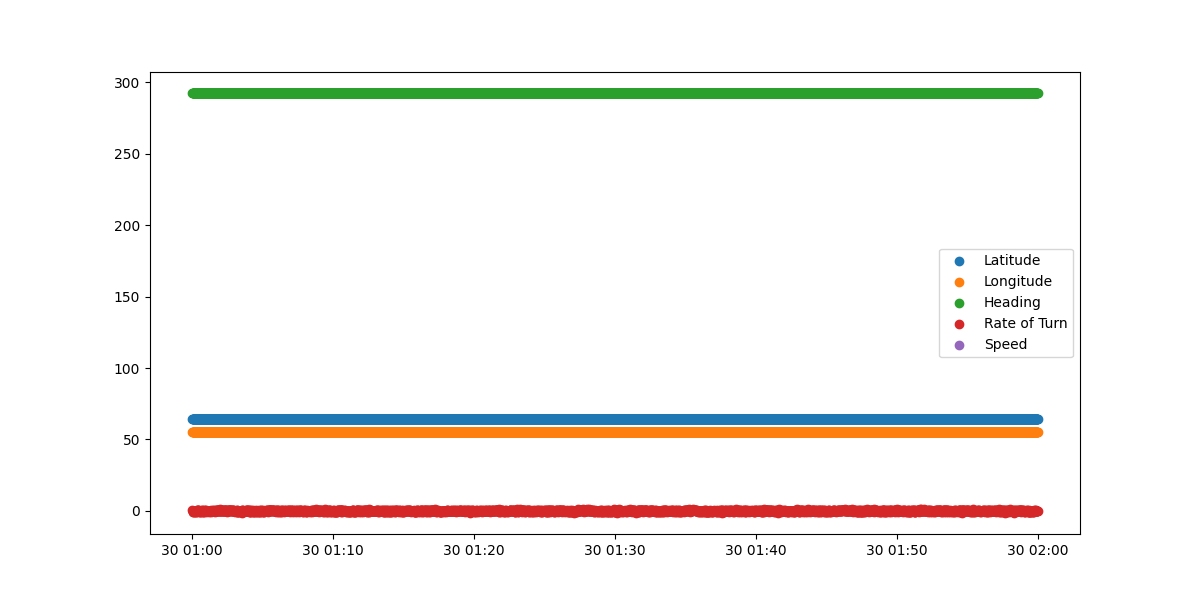

In [15]:
plt.figure(figsize=(12, 6))
plt.scatter(df_underway.index, df_underway['latitude'])
plt.scatter(df_underway.index, df_underway['longitude'])
plt.scatter(df_underway.index, df_underway['heading']) 
plt.scatter(df_underway.index, df_underway['rate_of_turn'])
plt.scatter(df_underway.index, df_underway['speed'])   
plt.legend(['Latitude', 'Longitude', 'Heading', 'Rate of Turn', 'Speed'])

plt.show()

Wind data 

In [16]:
def read_cr6_data(filename):
    df = pd.read_csv(os.path.join(data_dir, 'CR6_hourly', filename),  delimiter='\t')
    df = df.iloc[2:].reset_index(drop=True)
    # Convert TIMESTAMP to datetime and set as index
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f', errors="coerce")
    df = df.set_index('TIMESTAMP')

    rad2deg = 180.0 / np.pi

    # Convert columns to numeric, replacing empty strings with NaN
    numeric_cols = ['SonicX', 'SonicY', 'SonicZ', 'SonicT',
                    'ShipSonicX', 'ShipSonicY', 'ShipSonicZ', 'ShipSonicT',
                    'RotX', 'RotY', 'RotZ', 'AccX', 'AccY', 'AccZ']
    
    for col in numeric_cols:
        df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate wind components
    result_df = pd.DataFrame(index=df.index)
    result_df['u_ms'] = df['SonicY'] / 100.0
    result_df['v_ms'] = df['SonicX'] / -100.0
    result_df['w_ms'] = df['SonicZ'] / 100.0
    result_df['t_degC'] = df['SonicT'] / 100.0
    
    result_df['u_ms_ship'] = df['ShipSonicY'] / 100.0
    result_df['v_ms_ship'] = df['ShipSonicX'] / -100.0
    result_df['w_ms_ship'] = df['ShipSonicZ'] / 100.0
    result_df['t_degC_ship'] = df['ShipSonicT'] / 100.0

    # Rotation and Acceleration
    result_df['rotx_degs'] = rad2deg * df['RotX'] / 1000.0
    result_df['roty_degs'] = rad2deg * df['RotY'] / 1000.0
    result_df['rotz_degs'] = rad2deg * df['RotZ'] / 1000.0
    result_df['accelx_g'] = df['AccX'] / -1000.0
    result_df['accely_g'] = df['AccY'] / -1000.0
    result_df['accelz_g'] = df['AccZ'] / -1000.0
    
    def despike_column(series, sigma_threshold=5):
        """
        Remove spikes from a time series using sigma-based method
        
        Parameters:
        -----------
        series : pandas.Series
            Input time series to despike
        sigma_threshold : float, optional
            Number of standard deviations to use as threshold (default: 5)
        
        Returns:
        --------
        pandas.Series
            Despiked time series with spikes replaced by NaN
        """
        # Calculate mean and standard deviation
        v_avg = series.mean()
        v_sdev = series.std()
        
        # Create a mask for non-spike values
        mask = np.abs(series - v_avg) < sigma_threshold * v_sdev
        
        # Return series with spikes replaced by NaN
        return series * mask
    
    # Apply despiking to relevant columns
    despike_columns = [
        'u_ms', 'v_ms', 'w_ms', 't_degC', 
        'u_ms_ship', 'v_ms_ship', 'w_ms_ship', 't_degC_ship',
        'rotx_degs', 'roty_degs', 'rotz_degs', 
        'accelx_g', 'accely_g', 'accelz_g'
    ]
    
    for col in despike_columns:
        result_df[col] = despike_column(result_df[col])

    return result_df



In [17]:
# Process the CR6 data
for filename in cr6_name:
    df_cr6 = read_cr6_data(filename)
    break

Water watcher

In [18]:
def read_cr800(filename):
    df = pd.read_csv(os.path.join(data_dir, 'cr800', filename), skiprows=1, delimiter=',')
    df = df.iloc[2:].reset_index(drop=True)
    # Convert TIMESTAMP to datetime and set as index
    df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], format='mixed')   
    df = df.set_index("TIMESTAMP")  # Set the timestamp as index
    df = df.iloc[:,3:]  # Select columns after index 3
    
    return df

In [19]:
for filename in cr800_name:
    df_cr800= read_cr800(filename)
    break

Metek

In [20]:

def read_metek_data (filename):
    # File path (update with your actual file location)


    # Regex pattern to extract valid lines with x, y, z, and t
    pattern = re.compile(
        r'(?P<datetime>\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{6}Z)\s+H:x =\s+(?P<x>-?\d+)\s+y =\s+(?P<y>-?\d+)\s+z =\s+(?P<z>-?\d+)\s+t =\s+(?P<t>-?\d+)'
    )

    # Read and process lines
    data = []
    with open(os.path.join(data_dir, 'Metek', filename)) as file:
        for line in file:
            match = pattern.search(line)
            if match:
                data.append(match.groupdict())

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Convert data types
    df["datetime"] = pd.to_datetime(df["datetime"])  
    df["x"] = df["x"].astype(float)
    df["y"] = df["y"].astype(float)
    df["z"] = df["z"].astype(float)
    df["t"] = df["t"].astype(float)

    df["x"] = df["x"]/ -100.0
    df["y"] = df["y"]/ 100.0
    df["z"] = df["z"] / 100.0
    df["t"] = df["t"]/ 100.0


    # Set datetime as index
    df.set_index("datetime", inplace=True)

    def despike_column(series, sigma_threshold=5):
            """
            Remove spikes from a time series using sigma-based method
            
            Parameters:
            -----------
            series : pandas.Series
                Input time series to despike
            sigma_threshold : float, optional
                Number of standard deviations to use as threshold (default: 5)
            
            Returns:
            --------
            pandas.Series
                Despiked time series with spikes replaced by NaN
            """
            # Calculate mean and standard deviation
            v_avg = series.mean()
            v_sdev = series.std()
            
            # Create a mask for non-spike values
            mask = np.abs(series - v_avg) < sigma_threshold * v_sdev
            
            # Return series with spikes replaced by NaN
            return series * mask
        
        # Apply despiking to relevant columns
    despike_columns = [
            'x', 'y', 'z', 't']
            
        
    for col in despike_columns:
        df[col] = despike_column(df[col])
        
    return df

In [21]:
for filename in metek_name:
    df_metek = read_metek_data(filename)
    break   

Picarro data 

In [22]:
def read_picarro_data(filename):
    df = pd.read_csv(os.path.join(data_dir, 'picarro_hourly', filename), sep='\t')
    
    # drop date and time columns
    df.set_index('datetime', inplace=True) 

    #add true and false value 
    #df_picarro['puff'] = df_picarro['solenoid_valve'] != 0 in data it is 32 fro some reason?     
    return df

In [23]:
for filename in Picarro_name:
    df_picarro = read_picarro_data(filename)
    break

Once there is a df for each hourly file:

Lag time 

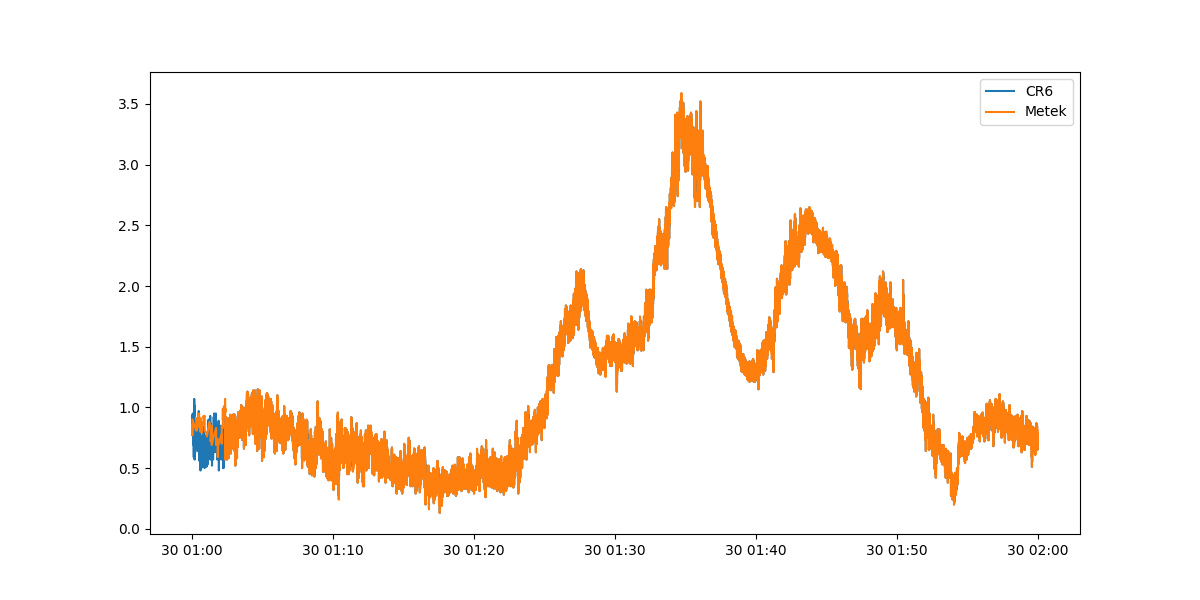

In [24]:
col_cr6 = df_cr6['v_ms']
col_metek = df_metek['x']
plt.figure(figsize=(12, 6))
plt.plot(col_cr6)
plt.plot(col_metek)
plt.legend(['CR6', 'Metek'])
plt.show()

Flag water watcher 